# Setting up our Notebook

In [1]:
# Things to import

# Standard data, plotting, and mathematical tools
import numpy as np
import pandas as pd
import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime

# SARIMAX Modeling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf
import pmdarima as pm
import statsmodels
import seaborn as sns

# Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# For serialization:
import joblib
import pickle

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Exponential Smoothing on BTC Closing Data

## Importing the Data

In [2]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [3]:
# Reading in the data and creating our X and y matrices

X=pd.read_csv(dfs[0])
y=X['Close']
y_pct_change=X['Percent Change']

X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)
X=X.drop('Close', axis=1)

Text(0.5, 1.0, 'BTC Price')

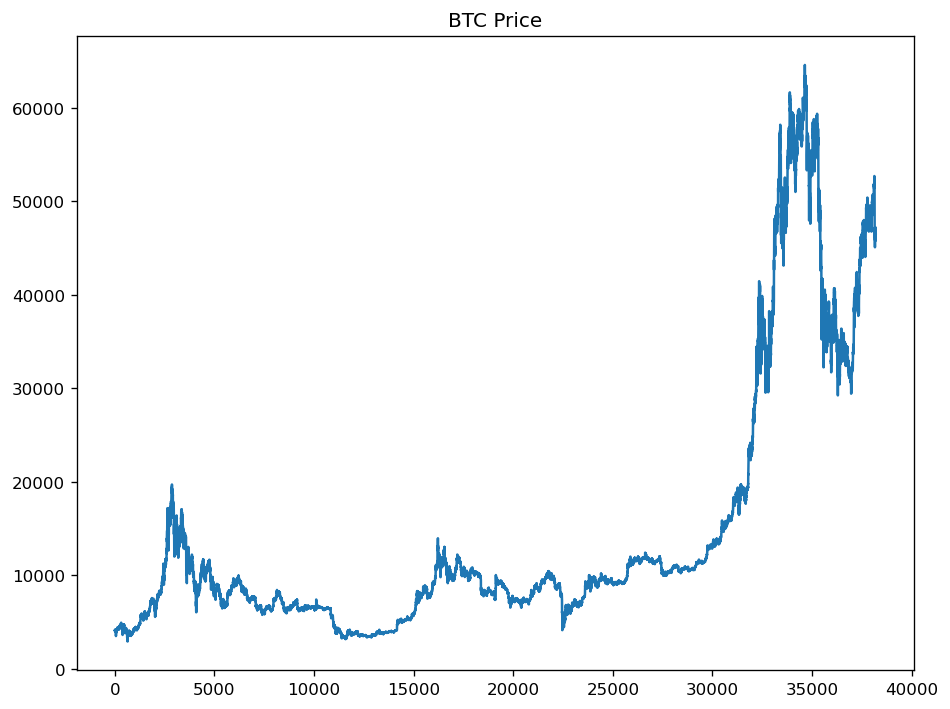

In [4]:
# Plotting our y

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plt.plot(y)
plt.title('BTC Price')

## Trend and Seasonality

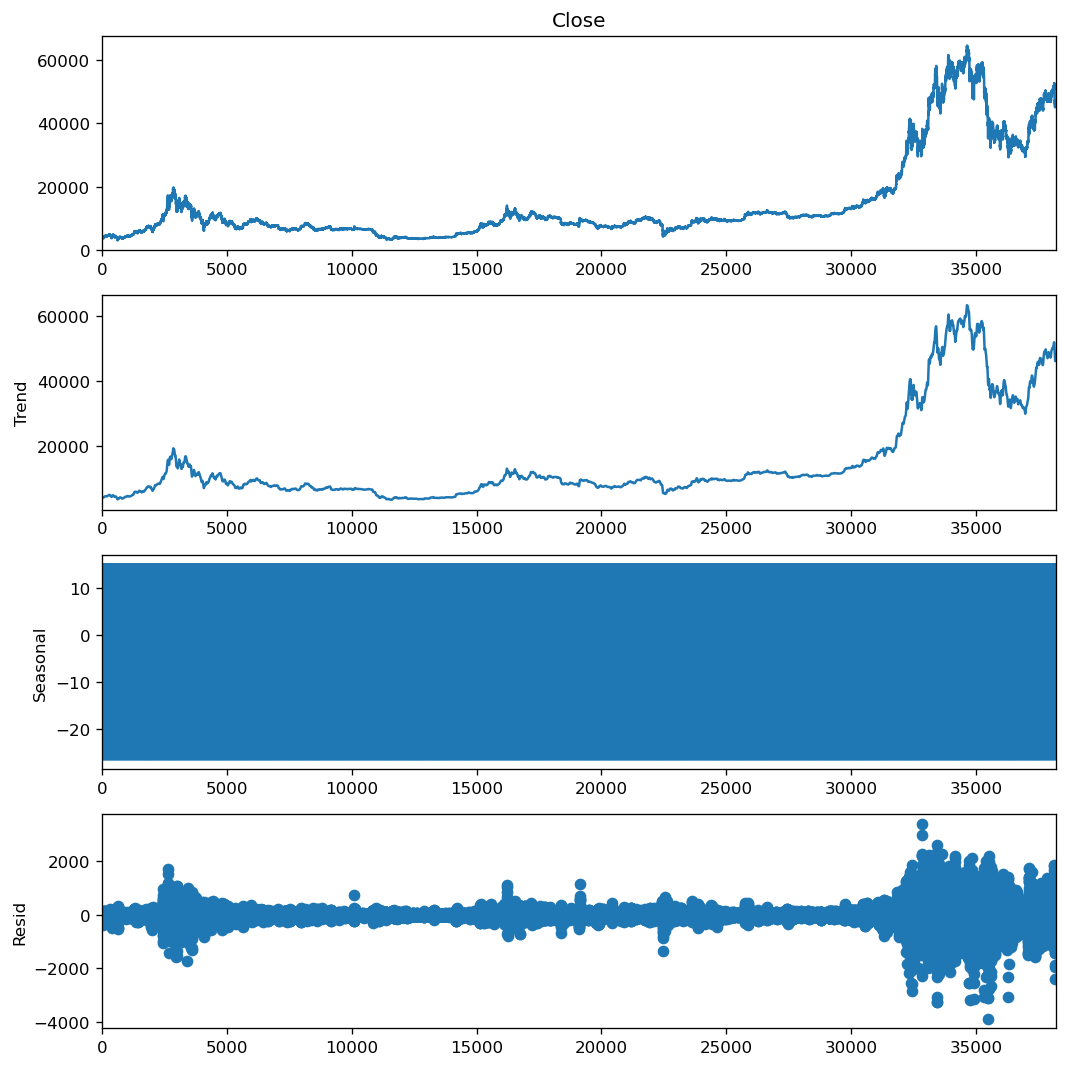

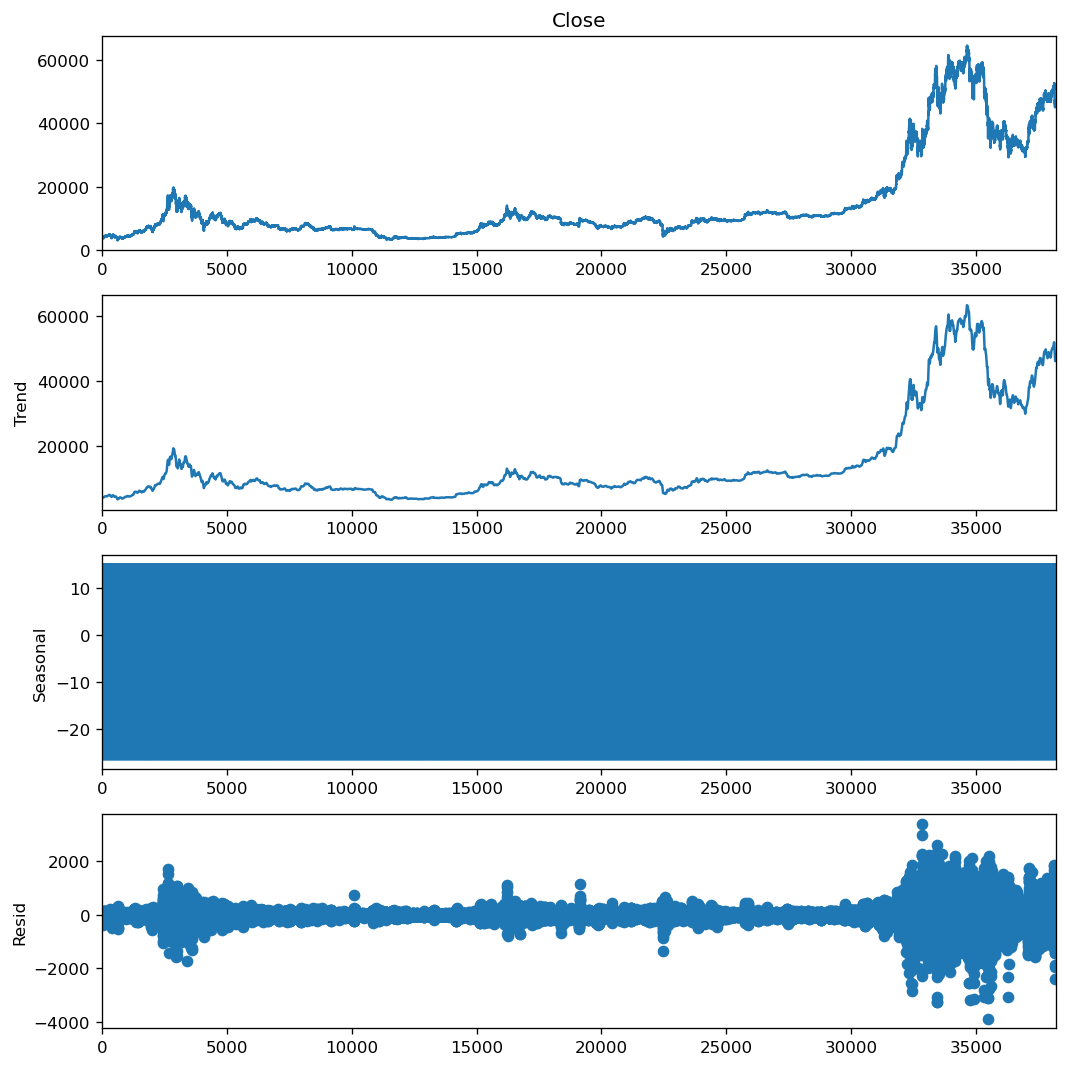

In [5]:
## from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Additive Decomposition
additive_decomposition = statsmodels.tsa.seasonal.seasonal_decompose(y, model='additive', period=30)

additive_decomposition.plot()
plt.tight_layout(rect=[0, 2, 1, 5])

# Multiplicative Decomposition
multiplicative_decomposition = statsmodels.tsa.seasonal.seasonal_decompose(y, model='multiplicative', period=30)

additive_decomposition.plot()
plt.tight_layout(rect=[0, 2, 1, 5])

plt.show()

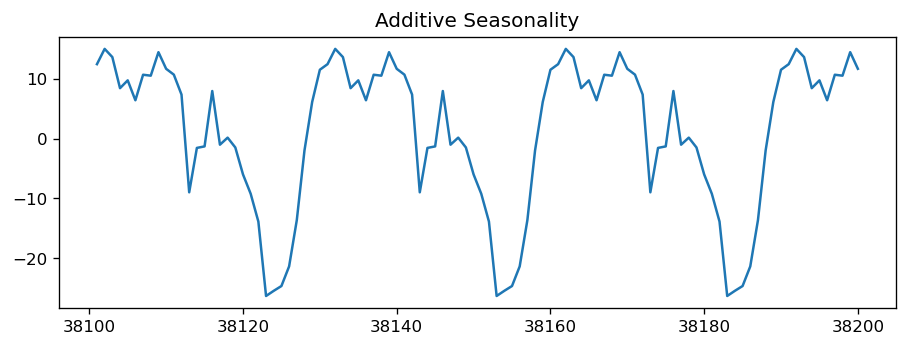

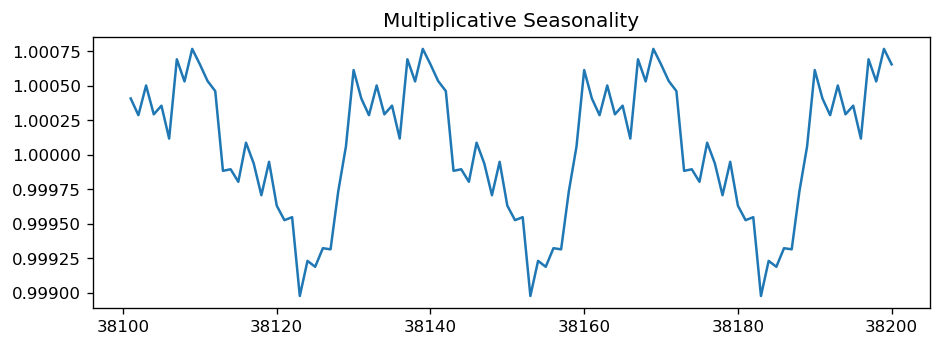

In [6]:
# plt.plot(additive_decomposition.seasonal[0:100])
add_season=additive_decomposition.seasonal[-100:]
plt.plot(add_season)
plt.title('Additive Seasonality')
plt.show()

mult_season=multiplicative_decomposition.seasonal[-100:]
plt.plot(mult_season)
plt.title('Multiplicative Seasonality')
plt.show()

We see an obvious trend and seasonality of 24 or so hours, so we will go with a Triple Exponential Smoothing, one with a Trend and Seasonal component

## Triple Exponential Smoothing

This section heavily follows: https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html

### Fitting our Models

In [36]:
# Fitting for Trend and Seasonality, where Trend can be Damped or not and Seasonality can be
# Multiplicative or Additive

fit1 = ExponentialSmoothing(
    y,
    seasonal_periods=24,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit2 = ExponentialSmoothing(
    y,
    seasonal_periods=24,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit3 = ExponentialSmoothing(
    y,
    seasonal_periods=24,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit4 = ExponentialSmoothing(
    y,
    seasonal_periods=24,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

In [37]:
results

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,8.889286e-01,8.889286e-01,8.889298e-01,8.889357e-01
$\beta$,9.990000e-05,1.036117e-04,9.718367e-05,9.244934e-05
$\phi$,NaN,NaN,9.900000e-01,9.900000e-01
$\gamma$,4.936508e-02,4.936505e-02,4.936448e-02,4.936170e-02
$l_0$,1.944888e+00,1.944886e+00,1.944876e+00,1.944851e+00
$b_0$,9.453851e-06,6.201849e-07,4.841601e-06,5.405218e-05
SSE,1.448369e+09,1.444246e+09,1.443291e+09,1.445337e+09


### Plotting

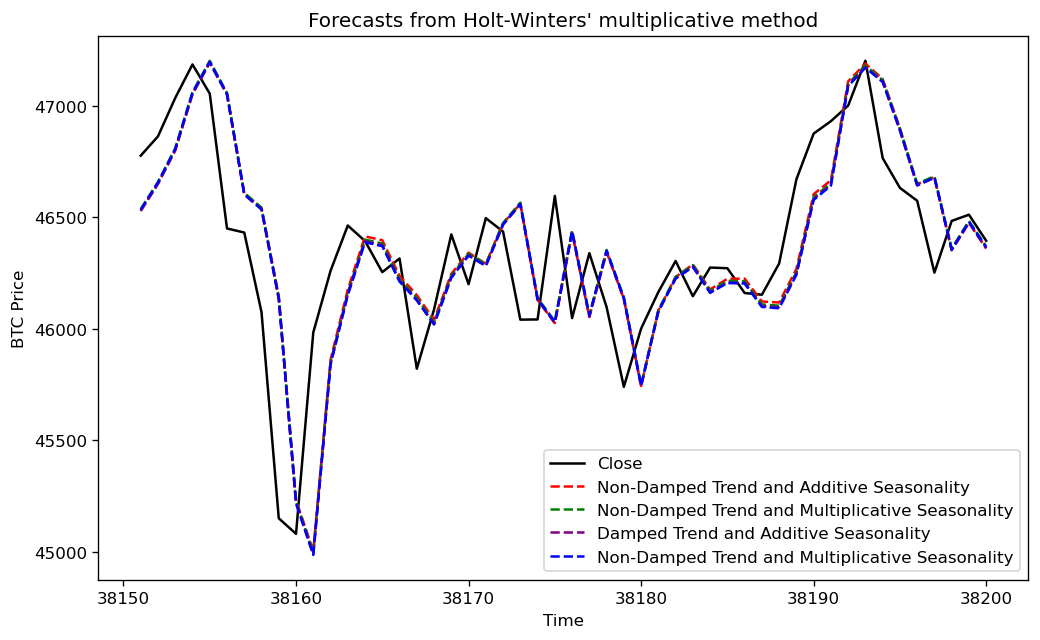

In [45]:
ax = y[-50:].plot(
    figsize=(10, 6),
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)
ax.set_ylabel("BTC Price")
ax.set_xlabel("Time")
fit1.fittedvalues[-50:].plot(ax=ax, style="--", color="red", 
                              label='Non-Damped Trend and Additive Seasonality')
fit2.fittedvalues[-50:].plot(ax=ax, style="--", color="green", 
                             label='Non-Damped Trend and Multiplicative Seasonality')
fit3.fittedvalues[-50:].plot(ax=ax, style="--", color="purple",
                             label='Damped Trend and Additive Seasonality')
fit4.fittedvalues[-50:].plot(ax=ax, style="--", color="blue",
                             label='Non-Damped Trend and Multiplicative Seasonality')
plt.legend()

# Forecasting
# fit1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(
#     ax=ax, style="--", marker="o", color="red", legend=True
# )

plt.show()

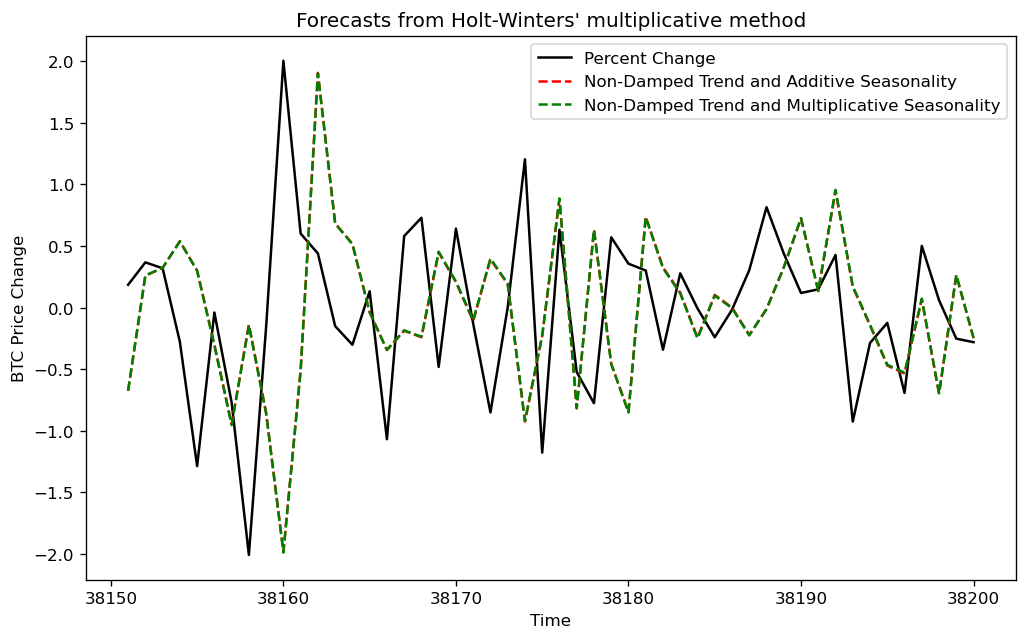

In [92]:
# Plotting the percent change of all the fits

# Getting the percent change of each fit
fit1_pct_change=100*fit1.fittedvalues.pct_change(1)
fit2_pct_change=100*fit2.fittedvalues.pct_change(1)
fit3_pct_change=100*fit3.fittedvalues.pct_change(1)
fit4_pct_change=100*fit4.fittedvalues.pct_change(1)

# Plotting
ax = y_pct_change[-50:].plot(
    figsize=(10, 6),
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)
ax.set_ylabel("BTC Price Change")
ax.set_xlabel("Time")
fit1_pct_change[-50:].plot(ax=ax, style="--", color="red", 
                              label='Non-Damped Trend and Additive Seasonality')
fit2_pct_change[-50:].plot(ax=ax, style="--", color="green", 
                             label='Non-Damped Trend and Multiplicative Seasonality')
# fit3_pct_change[-50:].plot(ax=ax, style="--", color="purple",
#                              label='Damped Trend and Additive Seasonality')
# fit4_pct_change[-50:].plot(ax=ax, style="--", color="blue",
#                              label='Non-Damped Trend and Multiplicative Seasonality')

plt.legend()
plt.show()